In [1]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

chdir


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.fhn import FHNModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# Single node simulation

In [47]:
fhn = FHNModel()
fhn.params['duration'] = 2.0*1000

Let's draw a simple one-dimensional bifurcation diagram of this model to orient ourselves in the parameter space

In [56]:
max_x = []
min_x = []
# these are the different input values that we want to scan
x_inputs = np.linspace(0, 2, 50)
for x_ext_mean in x_inputs:
    fhn.params['x_ext_mean'] = x_ext_mean
    fhn.run()
    # we add the maximum and the minimum of the last second of the 
    # simulation to a list
    max_x.append(np.max(fhn.x[0, -int(1000/fhn.params['dt']):]))
    min_x.append(np.min(fhn.x[0, -int(1000/fhn.params['dt']):]))

Text(0, 0.5, 'Min / max x')

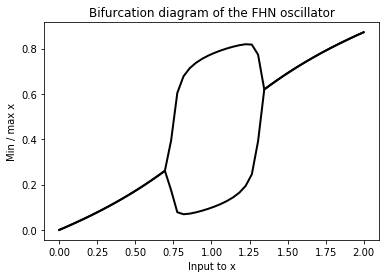

In [73]:
plt.plot(x_inputs, max_x, c='k', lw = 2)
plt.plot(x_inputs, min_x, c='k', lw = 2)
plt.title("Bifurcation diagram of the FHN oscillator")
plt.xlabel("Input to x")
plt.ylabel("Min / max x")

We can clearly see that there is a region (roughly for input values from `0.75` to `1.3`) at which a single node oscillates.

# Brain network

In [60]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [61]:
fhn = FHNModel(Cmat = ds.Cmat, Dmat = ds.Dmat, simulateBOLD=True)

In [69]:
fhn.params['signalV'] = 0
fhn.params['duration'] = 10 * 1000 
fhn.params['sigma_ou'] = .1
fhn.params['K_gl'] = 0.6
fhn.params['x_ext_mean'] = 0.72

fhn.run()

Text(0.5, 0, 't [ms]')

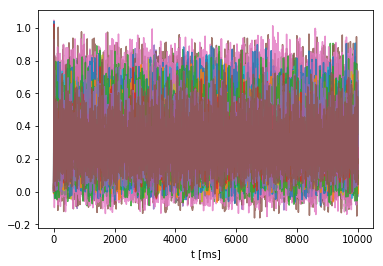

In [70]:
plt.plot(fhn.t, fhn.x[::5, :].T, alpha=0.8);
plt.xlabel("t [ms]")

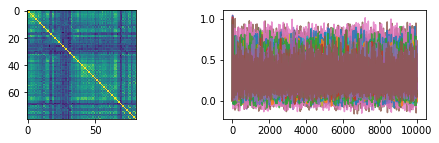

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].imshow(func.fc(fhn.x[:, -10000:]))
axs[1].plot(fhn.t, fhn.x[::5, :].T, alpha=0.8);

In [72]:
scores = []
for i in range(len(ds.FCs)):
    fc_score = func.matrix_correlation(func.fc(fhn.x[:, -int(5000/fhn.params['dt']):]), ds.FCs[i])
    scores.append(fc_score)
    print("Dataset {} correlation: {:.2f}". format(i, fc_score))
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Dataset 0 correlation: 0.56
Dataset 1 correlation: 0.49
Dataset 2 correlation: 0.55
Dataset 3 correlation: 0.55
Dataset 4 correlation: 0.54
Dataset 5 correlation: 0.47
Dataset 6 correlation: 0.62
Dataset 7 correlation: 0.52
Dataset 8 correlation: 0.65
Dataset 9 correlation: 0.62
Dataset 10 correlation: 0.52
Dataset 11 correlation: 0.51
Dataset 12 correlation: 0.54
Dataset 13 correlation: 0.51
Dataset 14 correlation: 0.64
Dataset 15 correlation: 0.57
Dataset 16 correlation: 0.55
Dataset 17 correlation: 0.47
Dataset 18 correlation: 0.54
Dataset 19 correlation: 0.57
Dataset 20 correlation: 0.56
Dataset 21 correlation: 0.55
Dataset 22 correlation: 0.52
Dataset 23 correlation: 0.64
Dataset 24 correlation: 0.39
Dataset 25 correlation: 0.51
Dataset 26 correlation: 0.65
Dataset 27 correlation: 0.50
Dataset 28 correlation: 0.48
Dataset 29 correlation: 0.50
Dataset 30 correlation: 0.56
Dataset 31 correlation: 0.51
Dataset 32 correlation: 0.51
Dataset 33 correlation: 0.63
Dataset 34 correlation: 